In [ ]:
%%capture
!pip install transformers

In [ ]:
from transformers import SamModel, SamProcessor
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image

In [ ]:
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
model = SamModel.from_pretrained("facebook/sam-vit-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
image = Image.open("/content/345.png").convert("RGB")

# Process the image and points
inputs = processor(images=image, return_tensors="tf")
# Perform segmentation
outputs = model(**inputs)

# masks = processor.image_processor.post_process_masks(
#     outputs.pred_masks,
#     inputs["original_sizes"],
#     inputs["reshaped_input_sizes"],
#     return_tensors="tf",
# )
# # # Extract segmentation mask


In [ ]:
masks = outputs.pred_masks.detach().cpu().numpy()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def display_masks_on_img(raw_image, masks, scores=None):
    """
    Display segmentation masks on an image in black and white format.

    Parameters:
    - raw_image: The original image (numpy array or PIL image).
    - masks: Array of masks (binary or multi-channel), shape (N, H, W) or (H, W).
    - scores: (Optional) List of scores for the masks.
    """
    # Convert raw_image to numpy array
    raw_image = np.array(raw_image)

    # Ensure masks are squeezed and binary
    masks = np.squeeze(masks)  # Remove any extra dimensions
    if len(masks.shape) == 2:  # If single mask
        masks = masks[None, ...]  # Add a batch dimension for consistency
    masks = masks > 0.5  # Ensure binary masks

    # Set up subplots
    nb_predictions = masks.shape[0]  # Number of masks
    fig, axes = plt.subplots(1, nb_predictions, figsize=(15, 15))

    if nb_predictions == 1:  # Handle single mask case
        axes = [axes]

    for i, mask in enumerate(masks):
        # Display the original image
        axes[i].imshow(raw_image, cmap="Blues")

        # Overlay the mask in black and white
        axes[i].imshow(mask, cmap="gray", alpha=0.4)  # Adjust alpha for transparency

        # Add titles with scores if provided
        if scores is not None:
            axes[i].set_title(f"Mask {i+1}, Score: {scores[i]:.3f}")
        else:
            axes[i].set_title(f"Mask {i+1}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()


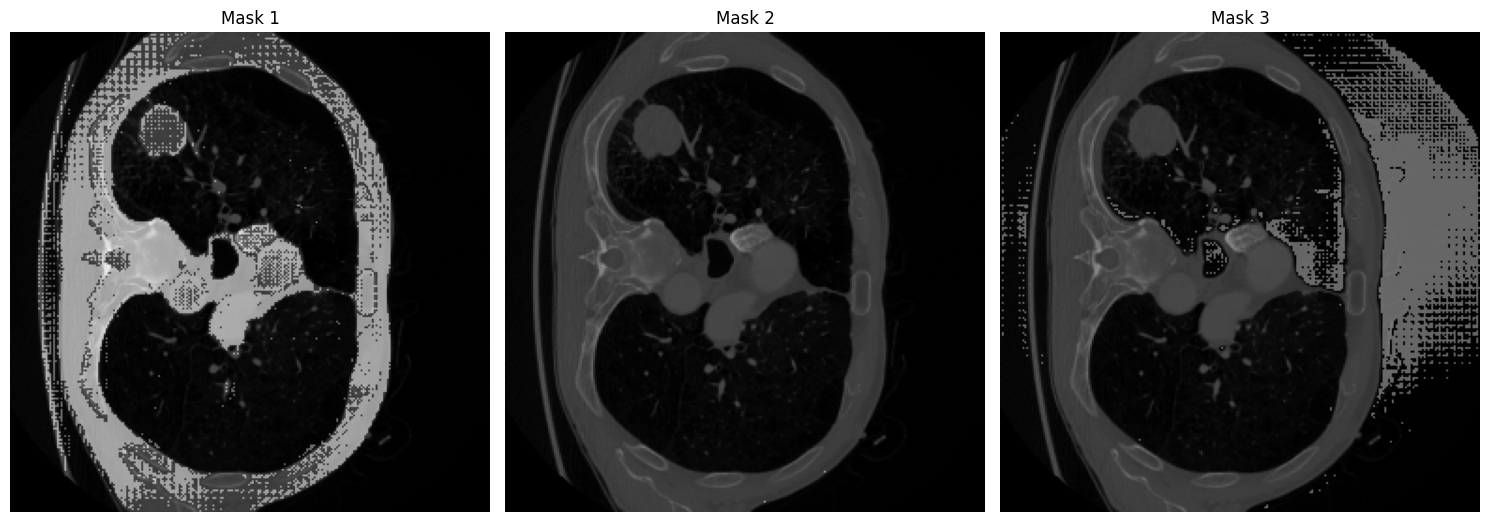

In [ ]:
display_masks_on_img(image, masks)

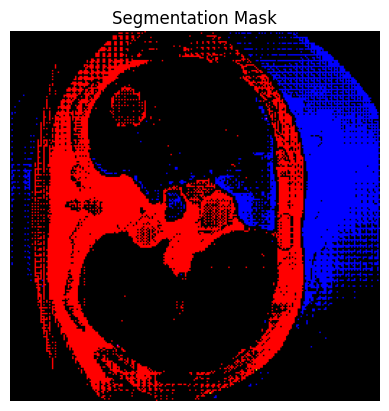

In [ ]:
import matplotlib.pyplot as plt
segmentation_mask = segmentation_mask.astype(np.float32)
plt.imshow(segmentation_mask.transpose(1, 2, 0), cmap="gray")
plt.title("Segmentation Mask")
plt.axis("off")
plt.show()


In [ ]:
%%capture
!pip install ultralytics

In [ ]:
from ultralytics import SAM

# Load a model
model = SAM("sam_b.pt")

# Display model information (optional)
model.info()

# Run inference with bboxes prompt
results = model("/content/103.png")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 358M/358M [00:08<00:00, 43.9MB/s]


Model summary: 243 layers, 93,735,472 parameters, 93,735,472 gradients



FileNotFoundError: /content/103.png does not exist

## Code with input points


In [ ]:
# Importing necessary libraries
from tensorflow import keras
from transformers import TFSamModel, SamProcessor   # Import SAM model and processor from transformers
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.ops.numpy_ops import np_config
from PIL import Image                      # Import Image from PIL for image operations
import requests                            # Import requests to make HTTP requests
import glob                                # Import glob for file path pattern matching
import os

# # Enable TensorFlow's numpy behavior for compatibility
np_config.enable_numpy_behavior()

# Function to display a mask on an image
def display_mask(mask, ax, random_color=False):
    # Random color for the mask if random_color is True
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else: # Default color
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_img = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_img)

# Function to display a bounding box on an image
def display_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=2))

# Function to display bounding boxes on an image
def display_boxes_on_img(raw_image, boxes):
    plt.figure(figsize=(10, 10))
    plt.imshow(raw_image)
    for box in boxes:
        display_box(box, plt.gca())
    plt.axis("on")
    plt.show()

# Function to display points on an image
def display_points_on_img(raw_image, input_points, input_labels=None):
    plt.figure(figsize=(10, 10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
        labels = np.ones_like(input_points[:, 0])
    else:
        labels = np.array(input_labels)
    display_points(input_points, labels, plt.gca())
    plt.axis("on")
    plt.show()

# Function to display both points and bounding boxes on an image
def display_points_and_boxes_on_img(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10, 10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
        labels = np.ones_like(input_points[:, 0])
    else:
        labels = np.array(input_labels)
    display_points(input_points, labels, plt.gca())
    for box in boxes:
        display_box(box, plt.gca())
    plt.axis("on")
    plt.show()

# Function to display points
def display_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="blue",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )

# Function to display masks on an image
def display_masks_on_img(raw_image, masks, scores):
    if len(masks[0].shape) == 4:
        final_masks = tf.squeeze(masks[0])
    if scores.shape[0] == 1:
        final_scores = tf.squeeze(scores)

    nb_predictions = scores.shape[-1]
    fig, axes = plt.subplots(1, nb_predictions, figsize=(15, 15))

    for i, (mask, score) in enumerate(zip(final_masks, final_scores)):
        mask = tf.stop_gradient(mask)
        axes[i].imshow(np.array(raw_image))
        display_mask(mask, axes[i])
        axes[i].title.set_text(f"Mask {i+1}, Score: {score.numpy().item():.3f}")
        axes[i].axis("off")
    plt.show()


In [ ]:
sam_model = TFSamModel.from_pretrained("facebook/sam-vit-huge")
sam_processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.56G [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFSamModel.

All the weights of TFSamModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFSamModel for predictions without further training.


preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

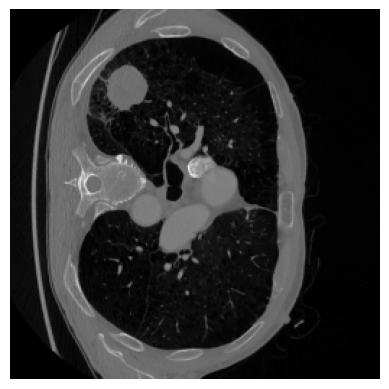

In [ ]:
import cv2

img_url = "/content/338.png"
raw_image = cv2.imread(img_url)

# Convert the image from BGR (OpenCV default) to RGB
raw_image_rgb = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)

# Display the image using matplotlib
plt.imshow(raw_image_rgb)
plt.axis('off')  # Hide axes for better visualization
plt.show()

In [ ]:
raw_image_rgb.shape

(256, 256, 3)

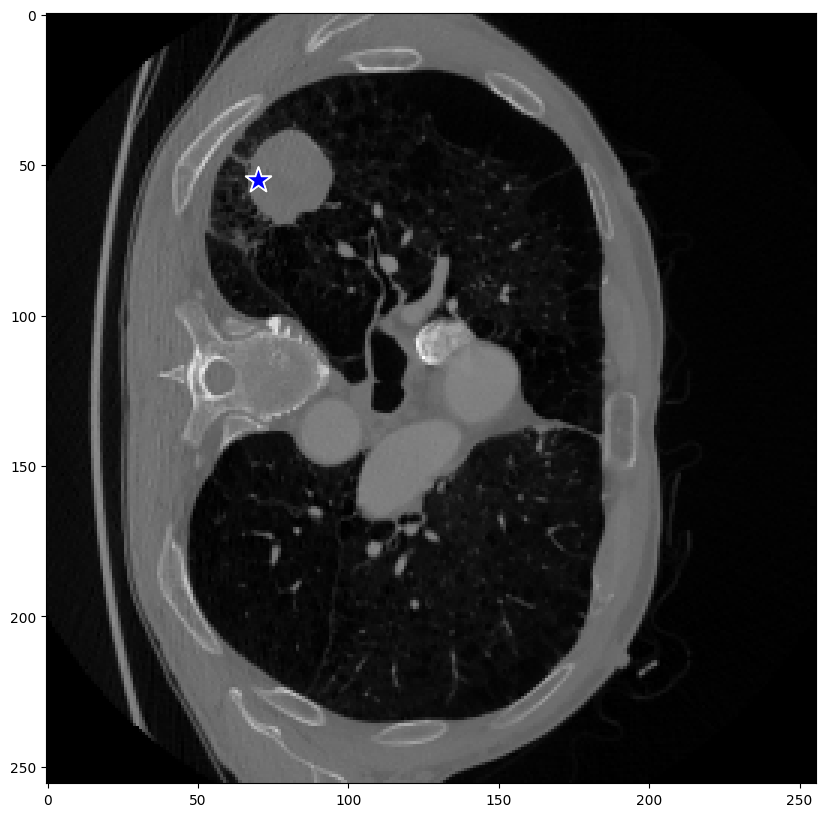

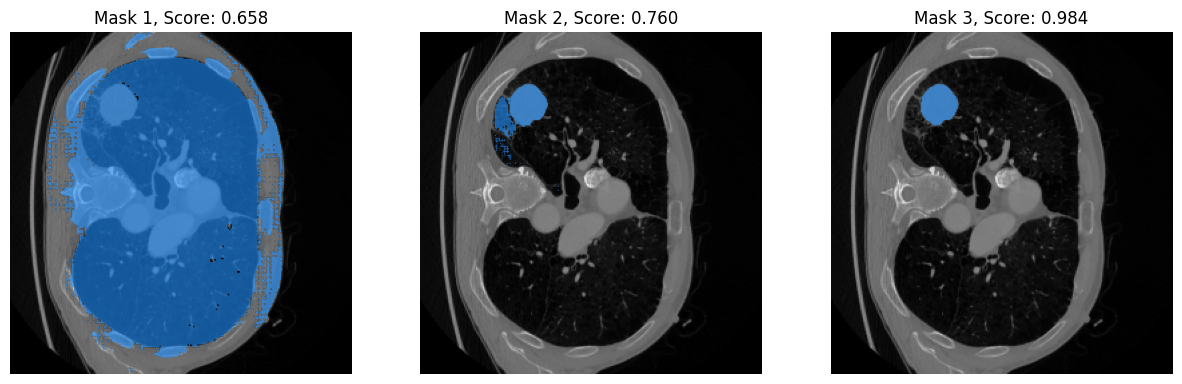

In [ ]:
# Define input points for segmentation
input_points = [[[70,55], [70,55]]]
# Visualize the input points on the image
display_points_on_img(raw_image, input_points[0])

# Preprocess the input image and points for the SAM model
inputs = sam_processor(raw_image, input_points=input_points, return_tensors="tf")

# Perform segmentation with the SAM model
outputs = sam_model(**inputs)

# Post-process the predicted masks for visualization
masks = sam_processor.image_processor.post_process_masks(
    outputs.pred_masks,
    inputs["original_sizes"],
    inputs["reshaped_input_sizes"],
    return_tensors="tf",
)

# Display the segmentation masks on the image along with their IOU scores
display_masks_on_img(raw_image, masks, outputs.iou_scores)

## Code without input points


All PyTorch model weights were used when initializing TFSamModel.

All the weights of TFSamModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFSamModel for predictions without further training.


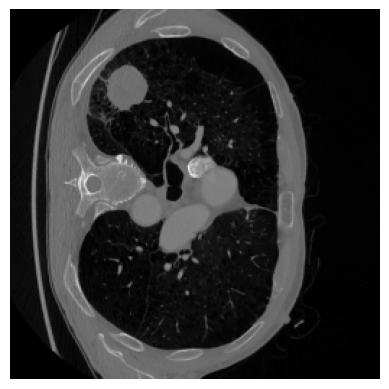

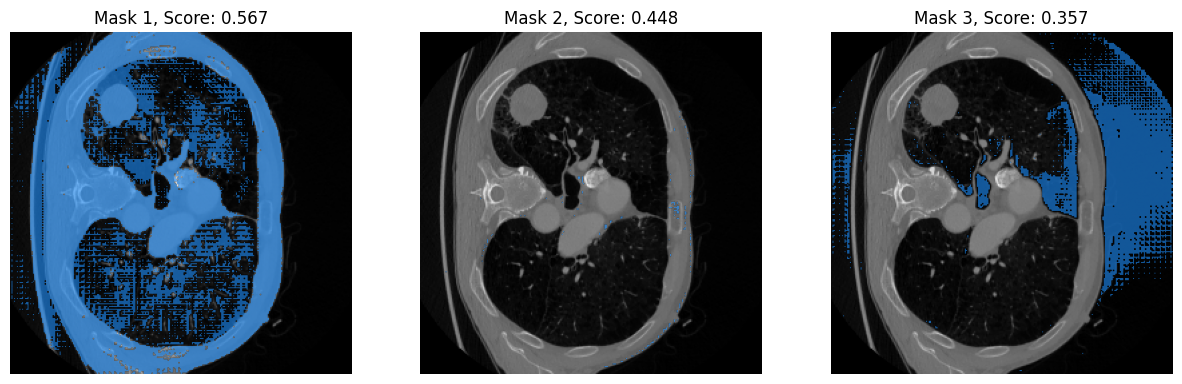

In [ ]:
from tensorflow import keras
from transformers import TFSamModel, SamProcessor
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.ops.numpy_ops import np_config
from PIL import Image
import cv2

# Enable TensorFlow's numpy behavior for compatibility
np_config.enable_numpy_behavior()

# Function to display a mask on an image
def display_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_img = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_img)

# Function to display masks on an image
def display_masks_on_img(raw_image, masks, scores):
    if len(masks[0].shape) == 4:
        final_masks = tf.squeeze(masks[0])
    if scores.shape[0] == 1:
        final_scores = tf.squeeze(scores)

    nb_predictions = scores.shape[-1]
    fig, axes = plt.subplots(1, nb_predictions, figsize=(15, 15))

    for i, (mask, score) in enumerate(zip(final_masks, final_scores)):
        mask = tf.stop_gradient(mask)
        axes[i].imshow(np.array(raw_image))
        display_mask(mask, axes[i])
        axes[i].title.set_text(f"Mask {i+1}, Score: {score.numpy().item():.3f}")
        axes[i].axis("off")
    plt.show()

# Load the SAM model and processor
sam_model = TFSamModel.from_pretrained("facebook/sam-vit-base")
sam_processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Load and preprocess the image
img_url = "/content/338.png"
raw_image = cv2.imread(img_url)
raw_image_rgb = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(raw_image_rgb)
plt.axis('off')
plt.show()

# Preprocess the input image for the SAM model
inputs = sam_processor(raw_image_rgb, return_tensors="tf")

# Perform segmentation with the SAM model
outputs = sam_model(**inputs)

# Post-process the predicted masks for visualization
masks = sam_processor.image_processor.post_process_masks(
    outputs.pred_masks,
    inputs["original_sizes"],
    inputs["reshaped_input_sizes"],
    return_tensors="tf",
)

# Display the segmentation masks on the image along with their IOU scores
display_masks_on_img(raw_image_rgb, masks, outputs.iou_scores)


----

# 1- Data Prep

In [ ]:
import os
import numpy as np
import shutil
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import SamProcessor
from torch.utils.data import DataLoader
from torch.optim import Adam
import monai
from transformers import SamModel
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [ ]:
def ensure_dir(directory):
    """Ensure output directory exists for saving images and masks,if not create it."""
    if not os.path.exists(directory):
        os.makedirs(directory)

def prepare_output_dirs(output_dir):
    """Create and return output directories for images and masks."""
    output_images_dir = os.path.join(output_dir, 'images')
    output_masks_dir = os.path.join(output_dir, 'masks')

    # Ensure output directories exist
    ensure_dir(output_images_dir)
    ensure_dir(output_masks_dir)
    return output_images_dir, output_masks_dir
def process_subjects(input_dir, output_dir, category):
    """Process subject folders, rename files, and copy to output directory."""
    # Sort subject folders for consistent processing order
    subject_folders = sorted(os.listdir(input_dir))

    print("--------------------------------------------------")
    print(f"Starting processing for category: {category}")
    # print("--------------------------------------------------")

    for subject_folder in subject_folders:
        subject_path = os.path.join(input_dir, subject_folder)
        if not os.path.isdir(subject_path):
            continue

        subject_id = subject_folder.split('_')[-1]  # Extract ID, e.g., "0" from "Subject_0"
        print("--------------------------------------------------")
        print(f"Processing Subject: {subject_folder} (ID: {subject_id}) - Category: {category}")
        print("--------------------------------------------------")

        # Get all files in the subject folder and sort them for consistency
        file_list = sorted([file_name for file_name in os.listdir(subject_path) if os.path.isfile(os.path.join(subject_path, file_name))])
        print(f"Number of files in {subject_folder} ({category}): {len(file_list)}")

        for file_name in file_list:
            file_path = os.path.join(subject_path, file_name)

            # Rename the file to subjectid_imagenumber
            new_file_name = f"{subject_id}_{file_name}"
            output_path = os.path.join(output_dir, new_file_name)

            # Copy file to output directory
            shutil.copy(file_path, output_path)
            print(f"Saved: {output_path}")

    print("--------------------------------------------------")
    print(f"Finished processing for category: {category}")
    print("--------------------------------------------------")

def process_folder(data_dir, output_dir):
    """Flatten folder structure, rename files, and save paths."""
    print("==================================================")
    print(f"Processing folder: {data_dir}")
    # print("==================================================")

    # Prepare output directories
    output_images_dir, output_masks_dir = prepare_output_dirs(output_dir)

    for category in ['images', 'masks']:
        input_dir = os.path.join(data_dir, category)
        output_category_dir = output_images_dir if category == 'images' else output_masks_dir

        # Process subjects in the input directory
        process_subjects(input_dir, output_category_dir, category)

    print("==================================================")
    print(f"Finished processing folder: {data_dir}")
    print("==================================================")

In [ ]:
def main():
    base_dir = "/kaggle/input/computer-vision-project"
    output_dir = "/kaggle/working/"

    # Process train and validation folders
    for folder in ['train', 'val']:
        data_dir = os.path.join(base_dir, folder)
        output_folder = os.path.join(output_dir, folder)
        process_folder(data_dir, output_folder)
main()

# 2- Helpers

In [ ]:
def visualize(img,mask,pred_mask=None):

    if isinstance(img, torch.Tensor):
        img = img.cpu().numpy()
    if isinstance(mask, torch.Tensor):
        mask = mask.cpu().numpy()

    if isinstance(pred_mask, torch.Tensor):
        pred_mask = pred_mask.cpu().numpy()

    if img.ndim == 3 and img.shape[0] == 1:  # Channels-first format (grayscale)
        img = img.squeeze(0)  # Remove the channel dimension
    if mask.ndim == 3 and mask.shape[0] == 1:  # Channels-first format (grayscale)
        mask = mask.squeeze(0)  # Remove the channel dimension
    if pred_mask is not None:
        if pred_mask.ndim == 3 and pred_mask.shape[0] == 1:  # Channels-first format (grayscale)
            pred_mask = pred_mask.squeeze(0)

    plt.figure(figsize=(15, 5))

    # Input Image
    plt.subplot(1, 5, 1)
    plt.imshow(img, cmap="gray" if img.ndim == 2 else None)
    plt.title("Input Image")
    plt.axis("off")

    # Ground Truth Mask
    plt.subplot(1, 5, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1, 5, 3)
    plt.imshow(img, cmap="gray" if img.ndim == 2 else None)
    plt.imshow(mask, cmap="gray", alpha=0.8)  # 'jet' for color mask and transparency with alpha
    plt.title("Input Image Ground Truth Mask")
    plt.axis("off")

    if pred_mask is not None:
        plt.subplot(1, 5, 4)
        plt.imshow(pred_mask, cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

        plt.subplot(1, 5, 5)
        plt.imshow(img, cmap="gray" if img.ndim == 2 else None)
        plt.imshow(pred_mask, cmap="gray", alpha=0.8)  # 'jet' for color mask and transparency with alpha
        plt.title("Input Image with Predicted Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Configs

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Used device {device}")
torch.manual_seed(1337)
if torch.cuda.is_available():
    torch.cuda.manual_seed(1337)
torch.set_float32_matmul_precision('highest')
torch.cuda.empty_cache()
batch_size = 4

# Dataset and Data Loading

In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self,images_dir,masks_dir,processor,transform=None):

        self.image_paths = sorted([os.path.join(images_dir, f) for f in os.listdir(images_dir) if os.path.isfile(os.path.join(images_dir, f))])
        self.mask_paths = sorted([os.path.join(masks_dir, f) for f in os.listdir(masks_dir) if os.path.isfile(os.path.join(masks_dir, f))])
        assert len(self.image_paths) == len(self.mask_paths), "Number of images and masks must be the same!"

        self.processor = processor
        self.transform = transform

    def __len__(self):
        """Return the total number of samples."""
        return len(self.image_paths)

    def __getitem__(self, idx):
        """Return an image and its corresponding mask."""

        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path)
        ground_truth_mask = np.array(mask)

        if self.transform:
            image = self.transform(image)
            # mask = self.transform(mask)

        prompt = self.get_bounding_box(ground_truth_mask, 1)  # Use get_bounding_box function
        inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

        # Remove batch dimension which the processor adds by default
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}

        # Add ground truth segmentation
        inputs["ground_truth_mask"] = ground_truth_mask

        return inputs


    def get_bounding_box(self, ground_truth_map):
      """Get bounding box coordinates for the tumor region (white pixels)."""
      print(f"Mask shape is {ground_truth_map.shape}")

      # Ensure the tumor region (white pixels) exists in the mask
      if np.sum(ground_truth_map == 255) == 0:
          raise ValueError("No tumor found in the mask.")

      # Get indices where the tumor (white pixels) is present
      y_indices, x_indices = np.where(ground_truth_map == 255)

      # Compute bounding box coordinates
      x_min, x_max = np.min(x_indices), np.max(x_indices)
      y_min, y_max = np.min(y_indices), np.max(y_indices)

      # Add random perturbations
      H, W = ground_truth_map.shape
      x_min = max(0, x_min - np.random.randint(0, 5))
      x_max = min(W, x_max + np.random.randint(0, 5))
      y_min = max(0, y_min - np.random.randint(0, 5))
      y_max = min(H, y_max + np.random.randint(0, 5))

      return [x_min, y_min, x_max, y_max]

In [ ]:
train_images_dir = '/kaggle/working/train/images'
train_masks_dir = '/kaggle/working/train/masks'

val_images_dir = '/kaggle/working/val/images'
val_masks_dir = '/kaggle/working/val/masks'

transform = transforms.Compose([
    transforms.Resize((1024, 1024)),
    transforms.ToTensor(),
])

train_dataset = SegmentationDataset(train_images_dir, train_masks_dir,transform)
val_dataset = SegmentationDataset(val_images_dir, val_masks_dir,transform)


print(f"Total samples in the train dataset: {len(train_dataset)}")
print(f"Total samples in the val dataset: {len(val_dataset)}")


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count(),pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count(),pin_memory=True)